Initialization

In [63]:
import pandas as pd
import keras
import tensorflow as tf
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [64]:
raw = pd.read_csv(
    "Regular_Dataset.csv"
)
print("Raw data Shape: ", raw.shape)
raw.head()

Raw data Shape:  (2636, 272)


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,AIn,AOut,AStr,AOff,Ablock,APSxG,APSxG+/-,AWon,Alosts,AWon%
0,10/01/2017,Arsenal,Brighton,2,0,H,1,0,H,K Friend,...,5,0,0,3,8,2.7,0.7,13,30,30.2
1,10/01/2017,Everton,Burnley,0,1,A,0,1,A,J Moss,...,3,0,0,1,10,0.3,0.3,34,32,51.5
2,10/01/2017,Newcastle,Liverpool,1,1,D,1,1,D,C Pawson,...,2,3,0,2,10,1.3,0.3,20,16,55.6
3,12/02/2017,Arsenal,Man United,1,3,A,0,2,A,A Marriner,...,1,0,0,0,7,5.0,4.0,24,11,68.6
4,12/02/2017,Watford,Tottenham,1,1,D,1,1,D,M Atkinson,...,1,0,1,10,6,0.2,-0.8,15,19,44.1


In [65]:
filtered = pd.read_csv('Filtered_Dataset.csv')
print("Filtered data Shape: ", filtered.shape)
filtered.head()

Filtered data Shape:  (2636, 160)


,FTHG,FTAG,HS,AS,HST,AST,HF,AF,HC,AC,...,ASoTA,ASaves,Alives,AFKF,ACKs,Ablock,AWon,Alosts,AWon%,FTR
0,2,0,25,9,12,1,7,8,6,5,...,8,6,351,8,5,8,13,30,30.2,H
1,0,1,23,5,4,2,14,7,9,3,...,4,4,276,15,3,10,34,32,51.5,A
2,1,1,8,17,5,2,11,6,1,5,...,5,4,625,11,5,10,20,16,55.6,D
3,1,3,33,8,15,4,11,10,12,1,...,14,13,200,15,1,7,24,11,68.6,A
4,1,1,6,8,2,2,16,8,7,2,...,2,1,403,15,2,6,15,19,44.1,D


Pre-processing Regular Dataset

In [78]:
from sklearn import decomposition, discriminant_analysis
from sklearn.preprocessing import StandardScaler
data = pd.DataFrame()

categorical_columns = ["HomeTeam", "AwayTeam"]
unimportant_columns = ["Date", "FTHG", "FTAG", "FTR", "HTHG", "HTAG", "HTR", "Referee"]


# Everything else is a numerical column
numerical_columns = [column for column in raw.columns.values if column not in categorical_columns + unimportant_columns]

# Copy the numerical columns over
one_hot_encoded_columns = [pd.get_dummies(raw[column], prefix=column) for column in categorical_columns]

# One-hot encode the categorical columns#
data = pd.concat([raw[numerical_columns]] + one_hot_encoded_columns, axis=1)
data = pd.concat([raw[numerical_columns]])
data = data.copy()

data['year'] = pd.to_datetime(raw['Date'], dayfirst=True).dt.year

data.head()

data['FTR'] = raw['FTR']

X = data.drop(columns=['FTR', 'year'])  # Features for training
y = data['FTR']  # Labels for training

train_data = X[data['year'] <= 2021]
train_labels = y[data['year'] <= 2021]

# Validation data
val_data = X[data['year'] == 2022]
val_labels = y[data['year'] == 2022]

# Test data
test_data = X[data['year'].between(2023, 2024)]
test_labels = y[data['year'].between(2023, 2024)]

# Remove rows with NaN in labels
train_data = train_data[train_labels.notna()]
train_labels = train_labels[train_labels.notna()]

val_data = val_data[val_labels.notna()]
val_labels = val_labels[val_labels.notna()]

test_data = test_data[test_labels.notna()]
test_labels = test_labels[test_labels.notna()]

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(train_data)
X_validation_std = scaler.transform(val_data)
X_test_std = scaler.transform(test_data)

# Apply PCA
pca = decomposition.PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_validation_pca = pca.transform(X_validation_std)
X_test_pca = pca.transform(X_test_std)

# Apply LDA
lda = discriminant_analysis.LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_std, train_labels)
X_validation_lda = lda.transform(X_validation_std)
X_test_lda = lda.transform(X_test_std)

Pre-processing Filtered Dataset

In [54]:
from sklearn import decomposition, discriminant_analysis
from sklearn.preprocessing import StandardScaler
X = filtered.drop(columns=['FTR'])
y = filtered['FTR']

X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_random, X_validation_random, y_train_random, y_validation_random = train_test_split(X, y, test_size=0.25, random_state=42)
X_validation_random, X_test_random, y_validation_random, y_test_random = train_test_split(X_validation_random, y_validation_random, test_size=0.5, random_state=42)
print(X_train_random.shape, X_validation_random.shape, X_test_random.shape)
print(y_train_random.shape, y_validation_random.shape, y_test_random.shape)

# Standardize the features
scaler = StandardScaler()
X_train_filtered = scaler.fit_transform(X_train_random)
X_validation_filtered = scaler.transform(X_validation_random)
X_test_filtered = scaler.transform(X_test_random)

(1977, 159) (329, 159) (330, 159)
(1977,) (329,) (330,)


Random Guess

In [55]:
class RandomGuessModel:
    def __init__(self, possible_outcomes):
        self.possible_outcomes = possible_outcomes

    def predict(self, n):
        return np.random.choice(self.possible_outcomes, n)

# Create an instance of the random guess model with possible outcomes
possible_outcomes = ['H', 'D', 'A']
random_guess_model = RandomGuessModel(possible_outcomes)

# Make predictions for validation and test sets
val_predictions = random_guess_model.predict(len(val_data))
test_predictions = random_guess_model.predict(len(test_data))

def evaluate_predictions(predictions, true_labels):
    accuracy = np.mean(predictions == true_labels)
    return accuracy

val_accuracy = evaluate_predictions(val_predictions, val_labels)
test_accuracy = evaluate_predictions(test_predictions, test_labels)

print("Validation Accuracy: ", val_accuracy)
print("Test Accuracy: ", test_accuracy)

Validation Accuracy:  0.3767313019390582
Test Accuracy:  0.32342657342657344


Confusion Matrix

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

def eval_model(model, test_data, test_labels, is_random_guess=False):
    # Make predictions
    if is_random_guess:
        test_predictions = model.predict(test_data.to_numpy())
    else:
        test_predictions = model.predict(test_data)

    # Classification evaluation
    cm = confusion_matrix(test_labels, test_predictions)
    accuracy = accuracy_score(test_labels, test_predictions)
    f1 = f1_score(test_labels, test_predictions, average='weighted')

    # Print classification report
    print(classification_report(test_labels, test_predictions, target_names=['Home Win', 'Draw', 'Away Win']))

    # Plot classification confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    cm_display = ConfusionMatrixDisplay(cm, display_labels=['Home Win', 'Draw', 'Away Win'])
    cm_display.plot(ax=ax)
    plt.title(f"Classification Confusion Matrix - Accuracy: {accuracy:.2f}, F1-Score: {f1:.2f}")
    plt.show()

Random Forest (Standardised Dataset)

Validation Accuracy:  0.9196675900277008
Test Accuracy:  0.75
Evaluating Random Forest model on validation data...hi
              precision    recall  f1-score   support

    Home Win       0.78      0.84      0.81       273
        Draw       0.72      0.53      0.61       130
    Away Win       0.72      0.78      0.74       169

    accuracy                           0.75       572
   macro avg       0.74      0.71      0.72       572
weighted avg       0.75      0.75      0.74       572



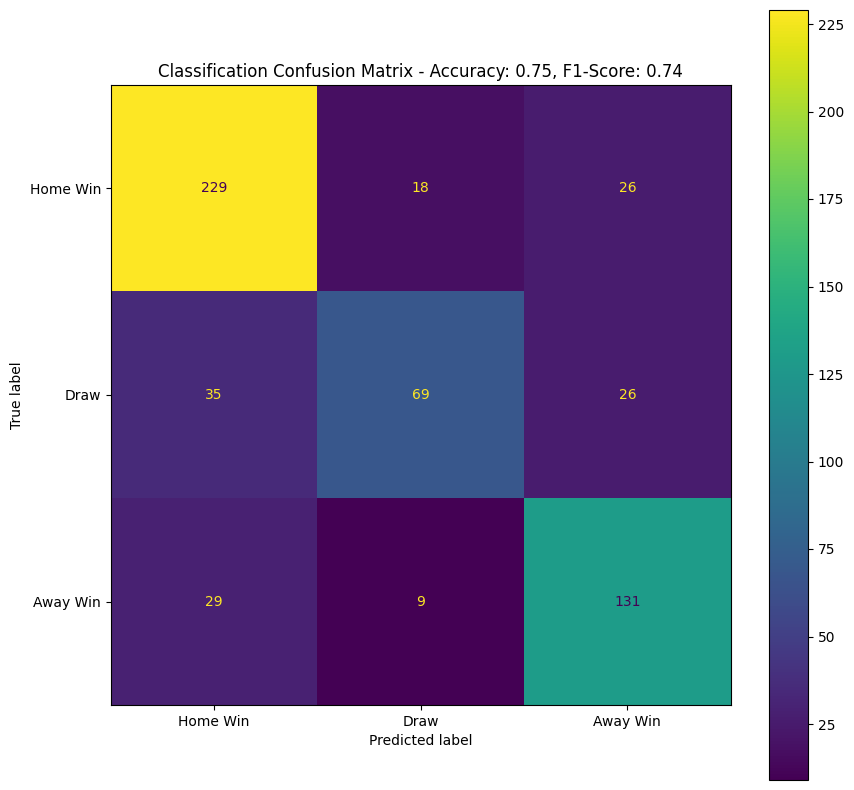

In [69]:
label_mapping = {'H': 0, 'D': 1, 'A': 2}
train_labels = train_labels.map(label_mapping)
val_labels = val_labels.map(label_mapping)
test_labels = test_labels.map(label_mapping)

rf_model_std = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model_std.fit(X_train_std, train_labels)

# Make predictions
val_predictions = rf_model_std.predict(X_validation_std)
test_predictions = rf_model_std.predict(X_test_std)

# Evaluate the model
val_accuracy = accuracy_score(val_labels, val_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Validation Accuracy: ", val_accuracy)
print("Test Accuracy: ", test_accuracy)

print("Evaluating Random Forest model on validation data...hi")
eval_model(rf_model_std, X_test_std, test_labels)

Random Forest (Filtered Dataset)

Validation Accuracy:  0.9331306990881459
Test Accuracy:  0.9151515151515152
Evaluating Random Forest model on validation data...hi
              precision    recall  f1-score   support

    Home Win       0.91      0.93      0.92       102
        Draw       0.90      0.84      0.87        82
    Away Win       0.93      0.95      0.94       146

    accuracy                           0.92       330
   macro avg       0.91      0.91      0.91       330
weighted avg       0.91      0.92      0.91       330



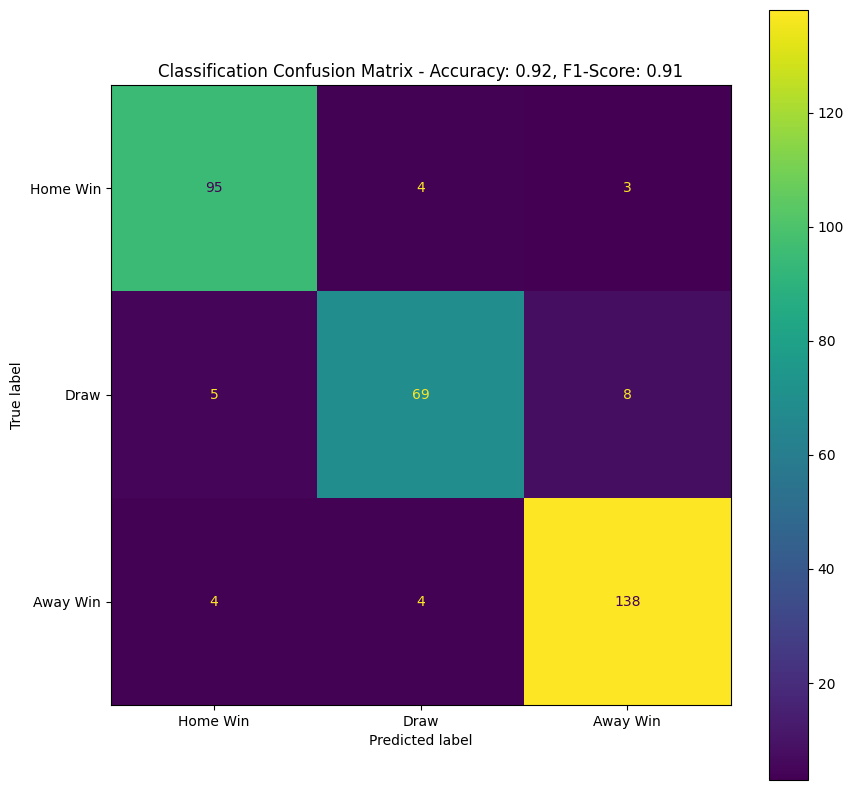

In [70]:
label_mapping = {'H': 0, 'D': 1, 'A': 2}
train_labels = train_labels.map(label_mapping)
val_labels = val_labels.map(label_mapping)
test_labels = test_labels.map(label_mapping)

rf_model_filtered = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model_filtered.fit(X_train_filtered, y_train_random)

# Make predictions
val_predictions = rf_model_filtered.predict(X_validation_filtered)
test_predictions = rf_model_filtered.predict(X_test_filtered)

# Evaluate the model
val_accuracy = accuracy_score(y_validation_random, val_predictions)
test_accuracy = accuracy_score(y_test_random, test_predictions)

print("Validation Accuracy: ", val_accuracy)
print("Test Accuracy: ", test_accuracy)

# Evaluate the Random Forest model on validation and test data
print("Evaluating Random Forest model on validation data...hi")
eval_model(rf_model_filtered, X_test_filtered, y_test_random)

Random Forest (PCA Dataset)

Validation Accuracy:  0.7506925207756233
Test Accuracy:  0.6381118881118881
Evaluating Random Forest model on validation data...hi
              precision    recall  f1-score   support

    Home Win       0.58      0.74      0.65       169
        Draw       0.53      0.07      0.12       130
    Away Win       0.68      0.85      0.75       273

    accuracy                           0.64       572
   macro avg       0.60      0.55      0.51       572
weighted avg       0.62      0.64      0.58       572



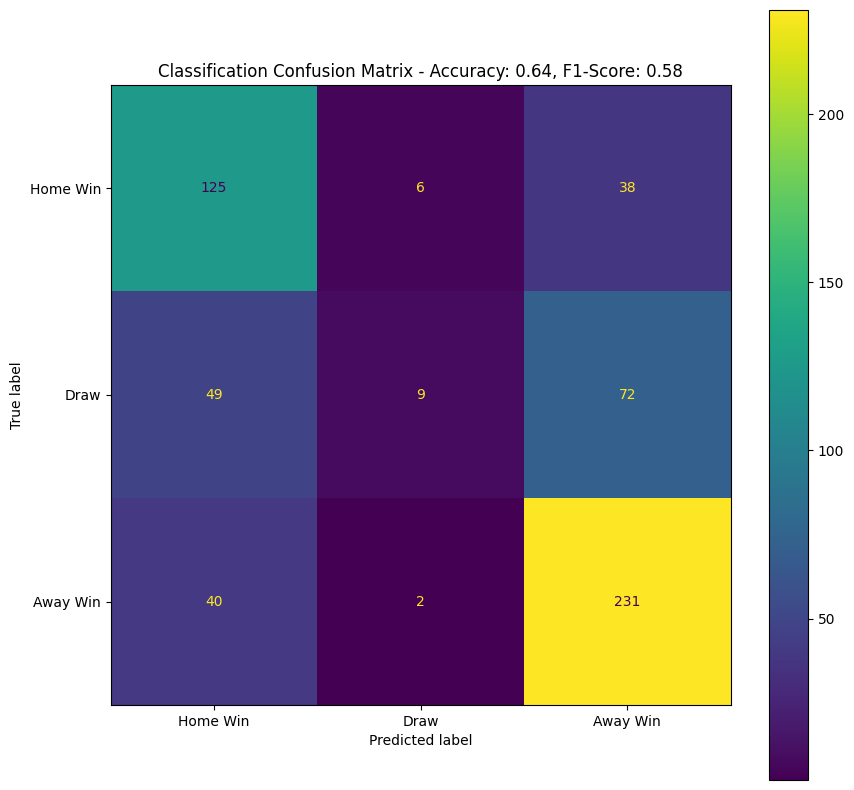

In [80]:
# Transform data with PCA
pca = decomposition.PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_validation_pca = pca.transform(X_validation_std)
X_test_pca = pca.transform(X_test_std)

# Train the Random Forest model
rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_pca.fit(X_train_pca, train_labels)

# Make predictions
val_predictions = rf_model_pca.predict(X_validation_pca)
test_predictions = rf_model_pca.predict(X_test_pca)

# Evaluate model performance
val_accuracy = accuracy_score(val_labels, val_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Validation Accuracy: ", val_accuracy)
print("Test Accuracy: ", test_accuracy)

# Evaluate the Random Forest model on validation and test data
print("Evaluating Random Forest model on validation data...hi")
eval_model(rf_model_pca, X_test_pca, test_labels)


Random Forest (LDA Dataset)

Validation Accuracy:  0.7534626038781164
Test Accuracy:  0.5699300699300699
Evaluating Random Forest model on test data...
              precision    recall  f1-score   support

    Home Win       0.90      0.48      0.62       273
        Draw       0.31      0.42      0.35       130
    Away Win       0.56      0.84      0.67       169

    accuracy                           0.57       572
   macro avg       0.59      0.58      0.55       572
weighted avg       0.66      0.57      0.58       572



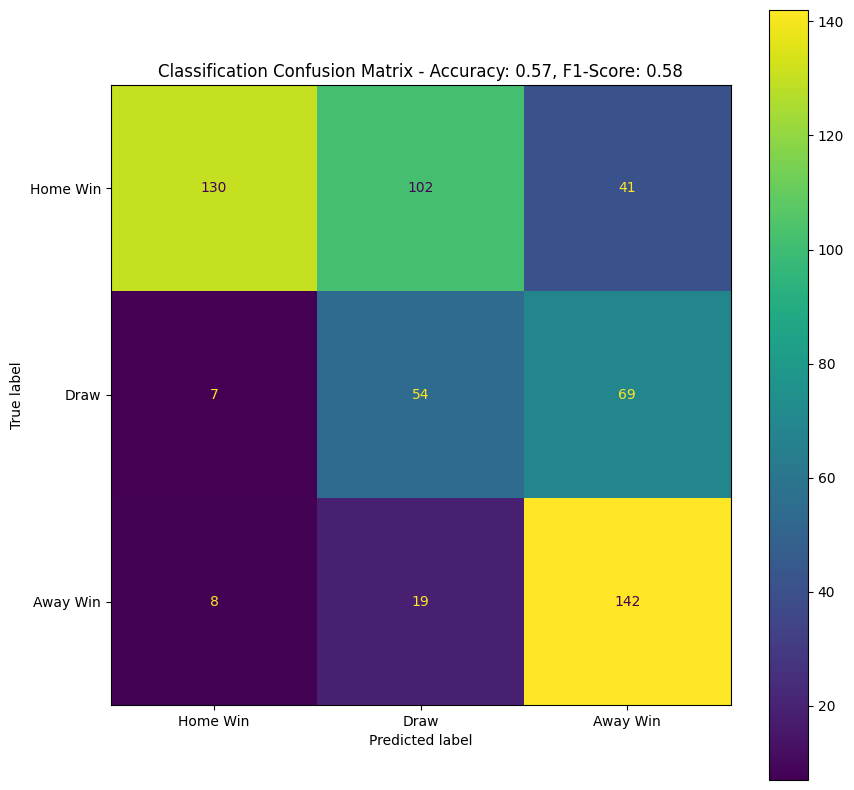

In [81]:
# Map the labels to integers
label_mapping = {'H': 0, 'D': 1, 'A': 2}
train_labels = train_labels.map(label_mapping)
val_labels = val_labels.map(label_mapping)
test_labels = test_labels.map(label_mapping)

# Train the model with LDA-transformed data
rf_model_lda = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_lda.fit(X_train_lda, train_labels)

# Make predictions
val_predictions = rf_model_lda.predict(X_validation_lda)
test_predictions = rf_model_lda.predict(X_test_lda)

# Evaluate the model
val_accuracy = accuracy_score(val_labels, val_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Validation Accuracy: ", val_accuracy)
print("Test Accuracy: ", test_accuracy)

# Evaluate using custom evaluation function
print("Evaluating Random Forest model on test data...")
eval_model(rf_model_lda, X_test_lda, test_labels)


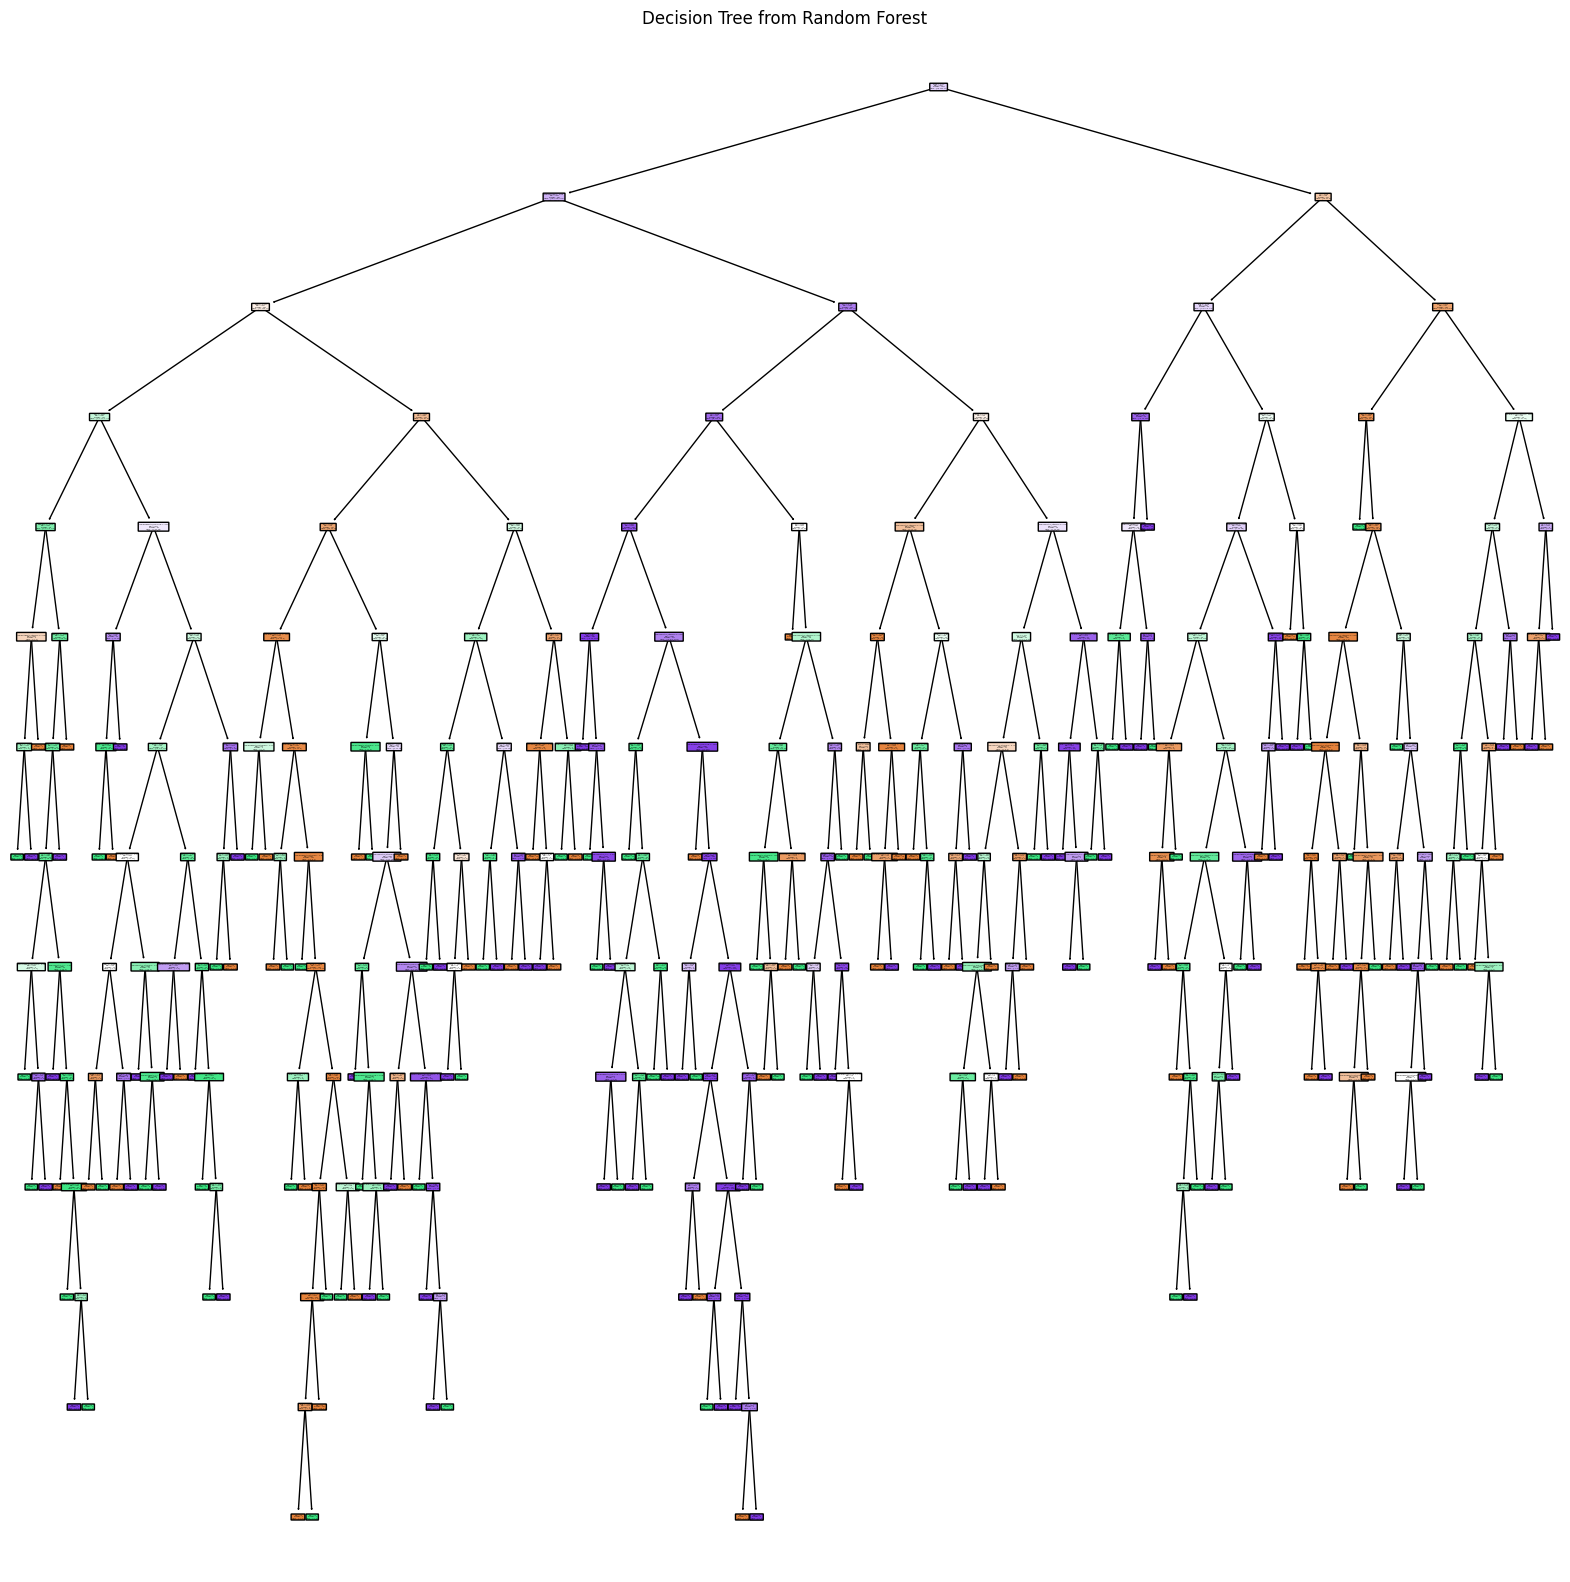

In [82]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

tree_index = 0  # You can change this index to plot a different tree

# Ensure your figure is large enough to see the tree details
plt.figure(figsize=(20,20))

# Plot the decision tree
plot_tree(rf_model_filtered.estimators_[tree_index],
          filled=True,
          rounded=True,
          class_names=['Home Win', 'Draw', 'Away Win'],
          feature_names=train_data.columns)

# Show the plot
plt.title("Decision Tree from Random Forest")
plt.show()

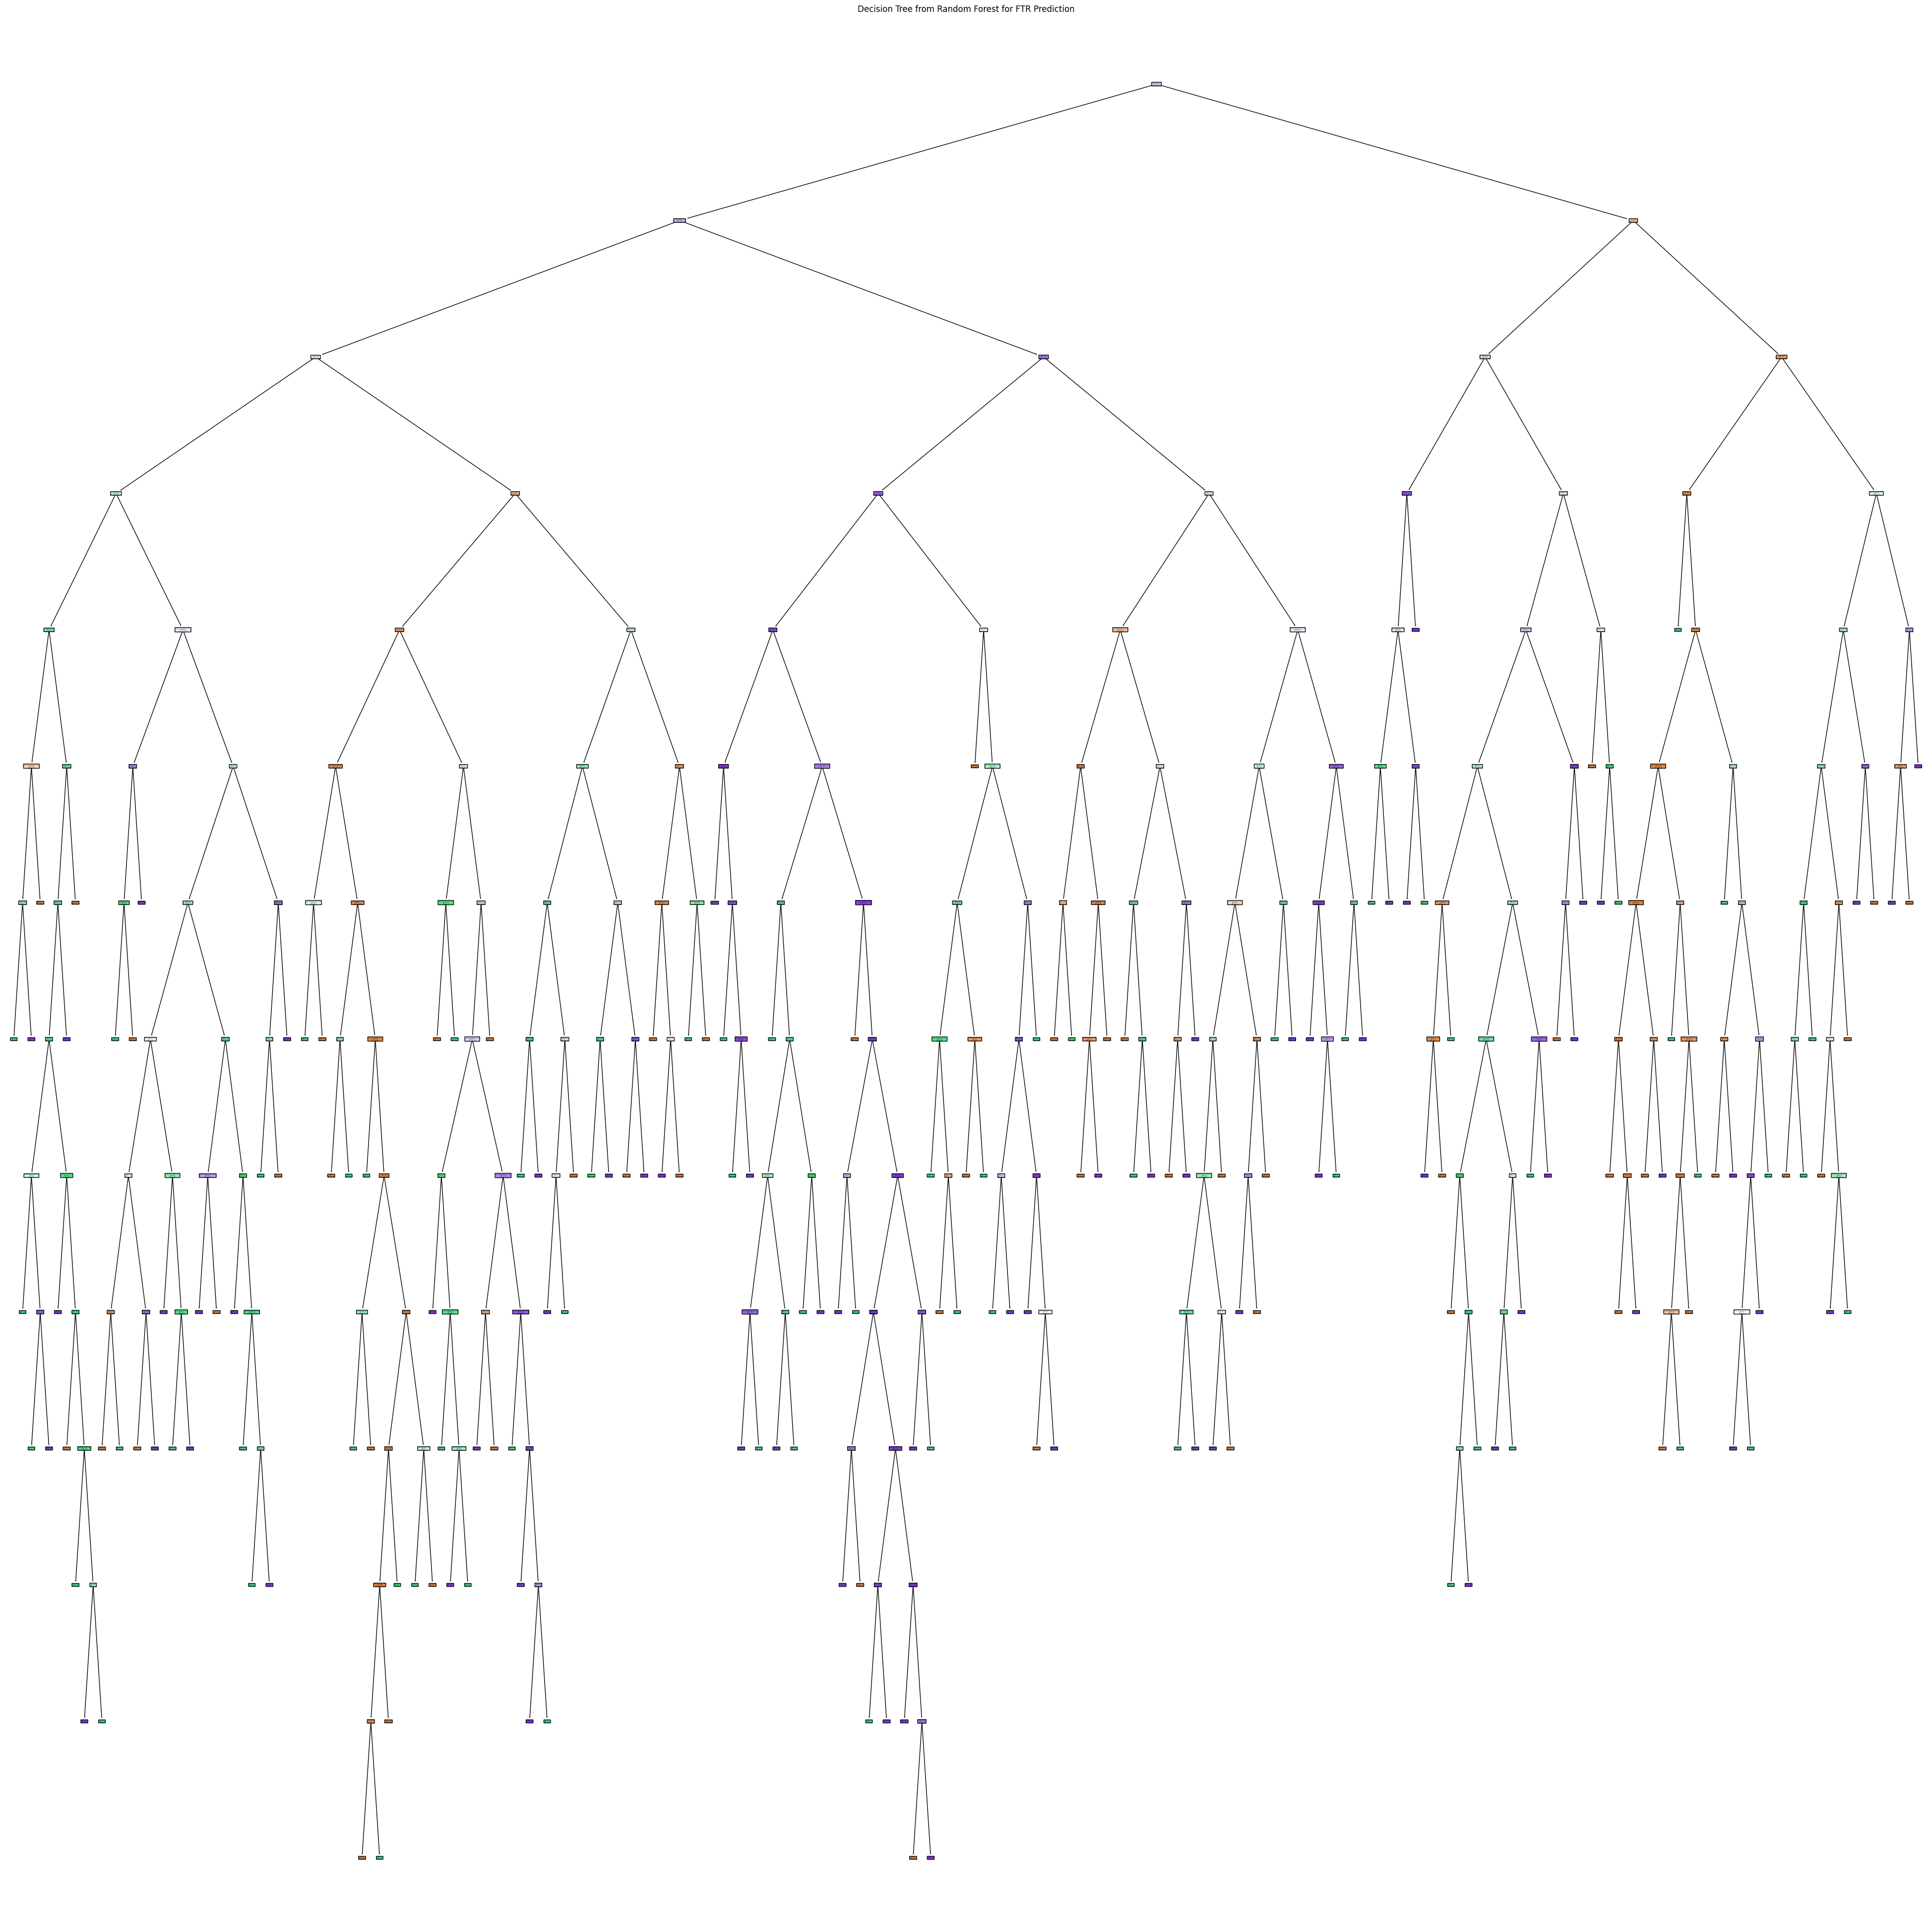

In [83]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Assuming you have already loaded and prepared your data
# Here's a reminder to ensure the correct loading and preprocessing of your data:
# train_data = pd.read_csv('path_to_your_train_data.csv')
# train_labels = train_data['FTR']  # Assuming 'FTR' column holds the Full Time Result labels
# train_data = train_data.drop(columns=['FTR'])  # Make sure to remove the label column from the training data set

# Initialize and train your Random Forest model
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(train_data, train_labels)

tree_index = 0  # You can change this index to plot a different tree from the Random Forest ensemble

# Ensure your figure is large enough to see the tree details clearly
plt.figure(figsize=(50,50))

# Plot the decision tree
plot_tree(rf_model_filtered.estimators_[tree_index],
          filled=True,
          rounded=True,
          class_names=['Home Win', 'Draw', 'Away Win'],  # This should correspond to the class labels used in 'FTR'
          feature_names=train_data.columns)

# Show the plot
plt.title("Decision Tree from Random Forest for FTR Prediction")
plt.show()